In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.test.utils import common_corpus, common_dictionary, common_texts
from gensim.models import LdaModel
from collections import Counter, defaultdict

In [2]:
np.random.seed(1)

In [3]:
common_corpus

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

In [4]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [5]:
dict(common_dictionary)

{0: 'computer',
 1: 'human',
 2: 'interface',
 3: 'response',
 4: 'survey',
 5: 'system',
 6: 'time',
 7: 'user',
 8: 'eps',
 9: 'trees',
 10: 'graph',
 11: 'minors'}

In [6]:
lda = LdaModel(corpus=common_corpus, num_topics=3, id2word=common_dictionary)

In [7]:
lda.get_topics()

array([[0.09991315, 0.03180536, 0.03219635, 0.08912607, 0.17471717,
        0.09523831, 0.09889168, 0.08675566, 0.03297976, 0.03802519,
        0.11181334, 0.10853791],
       [0.11099348, 0.19903353, 0.11578164, 0.03308505, 0.03267179,
        0.20439455, 0.03299609, 0.03511733, 0.11463977, 0.04719991,
        0.03913659, 0.03495036],
       [0.03130063, 0.02087262, 0.07347195, 0.08797028, 0.03108724,
        0.0874393 , 0.08150668, 0.1444235 , 0.07367393, 0.16928692,
        0.12514158, 0.07382545]], dtype=float32)

In [8]:
topic_names = [lda.id2word[i] for i in range(len(lda.id2word))]

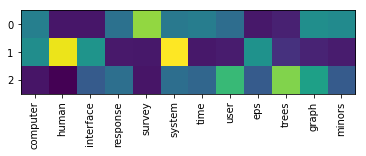

In [9]:
fig, ax = plt.subplots()
ax.imshow(lda.get_topics())
ax.set_xticks(np.arange(len(lda.id2word)))
ax.set_xticklabels(topic_names, rotation = 'vertical')
None

In [10]:
lda.get_topics().sum(axis=1)

array([1.       , 1.       , 1.0000001], dtype=float32)

In [11]:
lda.print_topics()

[(0,
  '0.175*"survey" + 0.112*"graph" + 0.109*"minors" + 0.100*"computer" + 0.099*"time" + 0.095*"system" + 0.089*"response" + 0.087*"user" + 0.038*"trees" + 0.033*"eps"'),
 (1,
  '0.204*"system" + 0.199*"human" + 0.116*"interface" + 0.115*"eps" + 0.111*"computer" + 0.047*"trees" + 0.039*"graph" + 0.035*"user" + 0.035*"minors" + 0.033*"response"'),
 (2,
  '0.169*"trees" + 0.144*"user" + 0.125*"graph" + 0.088*"response" + 0.087*"system" + 0.082*"time" + 0.074*"minors" + 0.074*"eps" + 0.073*"interface" + 0.031*"computer"')]

## Trying out collapsed gibbs

In [12]:
vocab_size = max(max(1 + v[0] for v in doc) for doc in common_corpus)
vocab_size

12

In [13]:
doc_lengths = [sum(x[1] for x in doc) for doc in common_corpus]
corpus_length = sum(doc_lengths)

In [14]:
doc_lengths

[3, 6, 4, 4, 3, 1, 2, 3, 3]

In [15]:
corpus_length

29

In [16]:
K = 3

In [17]:
# Initialization
Z = [np.random.choice(K, size=L) for L in doc_lengths]
Z

[array([0, 2, 2]),
 array([0, 1, 1, 2, 1, 2]),
 array([0, 1, 1, 0]),
 array([1, 1, 2, 2]),
 array([0, 2, 0]),
 array([2]),
 array([0, 2]),
 array([2, 0, 2]),
 array([0, 2, 0])]

In [18]:
burn_in = 10
lag = 20
num_samples = 100

In [19]:
import copy

In [20]:
import itertools

In [21]:
def flatten_one_level(L):
    return list(itertools.chain.from_iterable(L))

In [22]:
flatten_one_level([[1,2,3],[4,5,6],[7,8],[],[9]])

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [23]:
from tqdm import tqdm, tnrange, tqdm_notebook

In [24]:
class CollapsedGibbs(object):
    def fit(self, corpus, num_topics, vocab_size, burn_in = 10, lag = 20, num_samples = 100, alpha = 1.0, beta = 1.0):
        alpha = np.broadcast_to(alpha, (num_topics,))
        beta = np.broadcast_to(beta, (vocab_size,))
        beta_sum = beta.sum()
        lag = max(1, lag)
        burn_in = max(0, burn_in)
        num_samples = max(0, num_samples)

        doc_lengths = [sum(x[1] for x in doc) for doc in corpus]
        blank_counter = lambda: np.zeros((num_topics,), dtype='int')
        topic_counts = {
            "overall": blank_counter(),
            "by_doc": defaultdict(blank_counter),
            "by_vocab": defaultdict(blank_counter),
            "by_doc_vocab": defaultdict(blank_counter),
        }

        def sample_once(doc_index, vocab_index, topic_old):
            A = topic_counts["by_doc"][doc_index]
            B = topic_counts["by_vocab"][vocab_index]
            C = topic_counts["overall"]
            D = topic_counts["by_doc_vocab"][doc_index, vocab_index]
            if topic_old is not None:
                for x in [A, B, C, D]:
                    x[topic_old] -= 1
            probs = (alpha + A) * (beta[vocab_index] + B) / (beta_sum + C)
            probs /= probs.sum()
            topic_new = np.random.choice(num_topics, p = probs)
            for x in [A, B, C, D]:
                x[topic_new] += 1
        
        for di, doc in enumerate(tqdm_notebook(corpus, desc = "Initializing")):
            for v, c in doc:
                for pi in range(c):
                    sample_once(doc_index = di, vocab_index = v, topic_old = None)
        del di, doc, v, c, pi
        
        self.samples = []
        for i in tnrange(burn_in + lag * num_samples, desc = "Training"):
            for di, doc in enumerate(corpus):
                for v, vc in doc:
                    current_counts = topic_counts["by_doc_vocab"][di, v].copy()
                    for t, tc in enumerate(current_counts):
                        for j in range(tc):
                            sample_once(doc_index = di, vocab_index = v, topic_old = t)

            if i >= burn_in and (i - burn_in) % lag == 0:
                self.samples.append(copy.deepcopy(topic_counts))

        self.corpus = copy.deepcopy(corpus)
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.alpha = alpha.copy()
        self.beta = beta.copy()

    def topics_by_sample(self):
        counts = np.zeros((len(self.samples), self.num_topics, self.vocab_size))
        for si, sample in enumerate(self.samples):
            for (di, v), topic_count in sample["by_doc_vocab"].items():
                counts[si, :, v] += topic_count
        numer = counts + self.beta[np.newaxis, np.newaxis, :]
        denom = counts.sum(axis = 2, keepdims = True) + self.beta.sum()
        return numer / denom
        #return counts / counts.sum(axis = 2, keepdims = True)
        
    def cooccurrence_by_sample(self):
        num_samples = len(self.samples)
        result = np.zeros((num_samples, self.num_topics, self.num_topics))
        for si, sample in enumerate(self.samples):
            for di, topic_count in sample["by_doc"].items():
                probs = topic_count / topic_count.sum()
                result[si, :, :] += np.outer(probs, probs)
        result /= result.sum(axis = (1, 2), keepdims = True)
        return result

In [25]:
np.random.seed(1)

In [26]:
result = CollapsedGibbs()
result.fit(common_corpus, num_topics = 3, vocab_size = vocab_size, num_samples = 100)
len(result.samples)

100

In [27]:
T = result.topics_by_sample()

In [28]:
nan_indices = np.array(np.where(np.isnan(T)))
if nan_indices.size > 0:
    example_index = nan_indices[0, 0]
else:
    example_index = 0

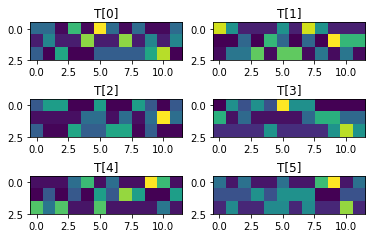

In [29]:
nr, nc = 3, 2
fig, ax = plt.subplots(nr, nc)
for i in range(nr * nc):
    ax[i // nc, i % nc].imshow(T[i])
    ax[i // nc, i % nc].set_title("T[{}]".format(i))
None

In [30]:
sums = T.sum(axis=2)
np.min(sums), np.max(sums)

(0.9999999999999998, 1.0000000000000002)

In [31]:
topics = T.mean(axis = 0)

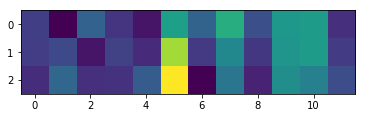

In [32]:
plt.imshow(topics);

In [33]:
[common_dictionary[i] for i in range(vocab_size)]

['computer',
 'human',
 'interface',
 'response',
 'survey',
 'system',
 'time',
 'user',
 'eps',
 'trees',
 'graph',
 'minors']

In [34]:
corpus_word_counts = Counter()
for doc in common_corpus:
    for w, c in doc:
        corpus_word_counts[w] += c
corpus_word_counts

Counter({0: 2,
         1: 2,
         2: 2,
         3: 2,
         4: 2,
         5: 4,
         6: 2,
         7: 3,
         8: 2,
         9: 3,
         10: 3,
         11: 2})

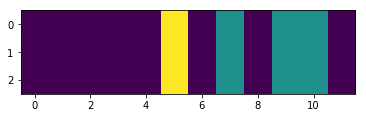

In [35]:
unif_topics = np.broadcast_to([corpus_word_counts[i] for i in range(vocab_size)], topics.shape).astype('float')
unif_topics /= unif_topics.sum(axis = 1, keepdims = True)
plt.imshow(unif_topics);

## Experiments with Griffiths-Steyvers square-image data generation

In [36]:
np.random.seed(1)

In [37]:
from sim_data import GriffithsSteyversSampler

In [38]:
sampler = GriffithsSteyversSampler(num_docs = 1000, words_per_doc = 100, dimension = 5, alpha = 0.1)
sampler.sample()
None

100%|██████████| 1000/1000 [00:07<00:00, 126.00it/s]


In [39]:
docs_to_display = 50

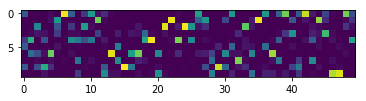

In [40]:
plt.imshow(np.array(sampler.doc_topic_mixtures)[:docs_to_display, :].T);

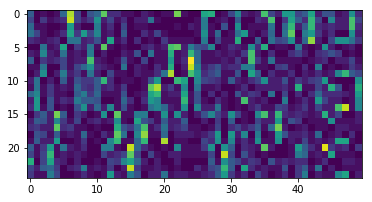

In [41]:
plt.imshow(sampler.data.toarray()[:docs_to_display, :].T);

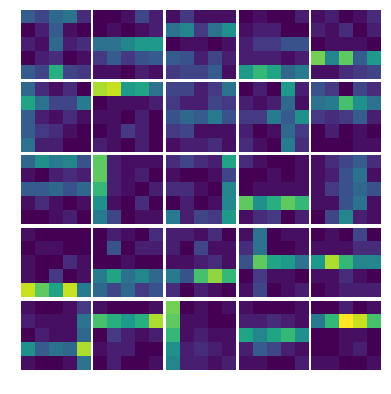

In [42]:
sq = 5
fig, ax = plt.subplots(sq, sq, figsize = (5, 5))
fig.subplots_adjust(hspace = 0.05, wspace = 0.05, left = 0, right = 1, top = 1, bottom = 0)
max_count = sampler.data[:docs_to_display, :].max()
for i in range(sq):
    for j in range(sq):
        n = i * sq + j
        if n < docs_to_display:
            X = sampler.data[n, :].toarray().reshape(sampler.dimension, sampler.dimension)
            ax[i, j].imshow(X, vmin = 0, vmax = max_count)
        ax[i, j].axis('off')

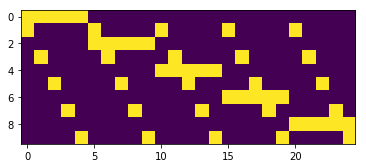

In [43]:
plt.imshow(sampler.topics);

In [44]:
%%time
lda = LdaModel(
    corpus=sampler.gensim_corpus,
    num_topics=sampler.num_topics,
    passes=20)

CPU times: user 25.7 s, sys: 77.5 ms, total: 25.8 s
Wall time: 26 s


In [45]:
topics = lda.get_topics()

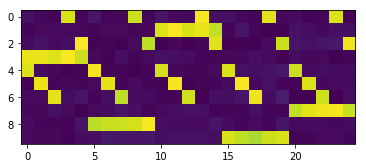

In [46]:
plt.imshow(topics);

In [47]:
np.random.seed(1)

In [48]:
result = CollapsedGibbs()
result.fit(
    corpus = sampler.gensim_corpus,
    num_topics = sampler.num_topics,
    vocab_size = sampler.vocab_size,
    num_samples = 20,
    lag = 1,
    burn_in = 10)
len(result.samples)

20

In [49]:
T = result.topics_by_sample()

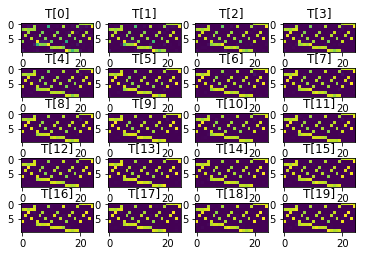

In [50]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc)
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(T[i])
    ax[i // nc, i % nc].set_title("T[{}]".format(i))
None

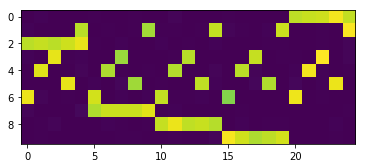

In [51]:
plt.imshow(T[-1]);

In [52]:
%%time
cooccur_by_sample = result.cooccurrence_by_sample()

CPU times: user 321 ms, sys: 4.49 ms, total: 325 ms
Wall time: 333 ms


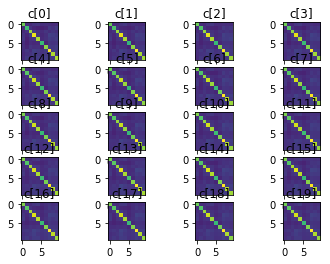

In [53]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc)
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(cooccur_by_sample[i], vmin=0)
    ax[i // nc, i % nc].set_title("c[{}]".format(i))
None

In [54]:
from sim_data import topics_griffiths_steyvers

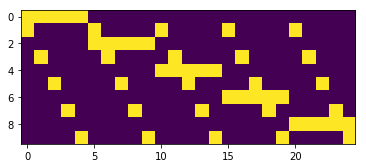

In [55]:
plt.imshow(topics_griffiths_steyvers(10));

### Try combining G.S. topics with tree-based model

In [56]:
import networkx as nx

In [57]:
from example_graphs import make_tree
from utils import nice_tree_plot, without_diag
from sim_data import HPAM2Sampler, get_alpha
from functools import partial

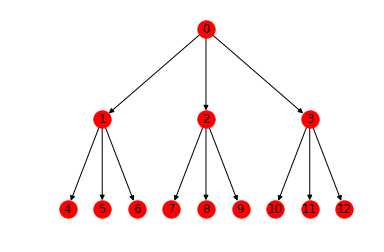

In [58]:
tree = make_tree([3,3])
nice_tree_plot(tree)

In [59]:
exact_topics = topics_griffiths_steyvers(tree.number_of_nodes())

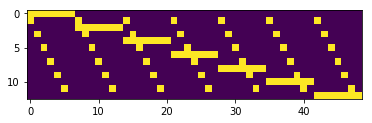

In [60]:
plt.imshow(exact_topics);

In [61]:
topic_func = lambda n: exact_topics[n, :]

In [62]:
np.random.seed(1)

In [63]:
h_sampler = HPAM2Sampler(
    tree,
    num_docs = 5000,
    words_per_doc = 500,
    vocab_size = exact_topics.shape[1],
    topic_dirichlet = None,
    topic_func = topic_func,
    alpha_func = partial(get_alpha, scale=0.1)
)

In [64]:
h_sampler.sample();

  2%|▏         | 87/5000 [00:05<05:11, 15.78it/s]


KeyboardInterrupt: 

In [ ]:
tree_corpus = []
for doc in h_sampler.docs:
    ctr = Counter(doc)
    doc_short = [(k, v) for k, v in ctr.items()]
    tree_corpus.append(doc_short)
len(tree_corpus)

In [ ]:
np.random.seed(3)
# NOTE: quality of results seem to have a lot of variance (to see this, try changing the random seed)

In [ ]:
result = CollapsedGibbs()
result.fit(
    corpus = tree_corpus,
    num_topics = h_sampler.g.number_of_nodes(),
    vocab_size = h_sampler.vocab_size,
    num_samples = 20,
    lag = 1,
    burn_in = 10)
len(result.samples)

In [ ]:
T = result.topics_by_sample()

In [ ]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc)
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(T[i])
    ax[i // nc, i % nc].set_title("T[{}]".format(i))
None

In [ ]:
plt.imshow(T[-1]);

In [ ]:
%%time
cooccur_by_sample = result.cooccurrence_by_sample()

In [ ]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc, figsize=(10,10))
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(without_diag(cooccur_by_sample[i]), vmin=0)
    ax[i // nc, i % nc].set_title("c[{}]".format(i))
None

In [ ]:
plt.imshow(without_diag(cooccur_by_sample[-1]), vmin=0);

In [ ]:
from tree_extraction import Aho

In [ ]:
tree_extracted = Aho.extract(cooccur_by_sample[-1])

In [ ]:
nice_tree_plot(tree_extracted)

In [ ]:
r = without_diag(cooccur_by_sample[nr * nc - 1])
imax = np.argmax(r)
coordmax = np.unravel_index(imax, r.shape)
rmax = r[coordmax]
rmax, coordmax

## Quick way to reload without rerunning everything

In [ ]:
from importlib import reload
import sim_data
reload(sim_data)
del sim_data